# Compare the 4 ML model configurations for individual Large Ensembles and full CMIP6

### Author - Chris Wyburn-Powell, see the latest version on [github](https://github.com/chrisrwp/low-frequency-variability/blob/main/neural_network/Analyze_4_ML_Models.ipynb)

**Input:**
- `CMIP6_modeling_center_members_doi.nc`
- `CMIP6_members_CVDP_and_SIC.pickle`
- `validation_r_values_4ML_<model_name>_<month>_month_var_9_best_season_LE_all_region_Sep_lowpass_filt.nc`
- `validation_r_values_4ML_CMIP6_month_<month>_var_9_best_season_LE_all_region_Sep_lowpass_filt_1920_2014.nc`
- `validation_r_values_4ML_CMIP6_30_month_<month>_var_9_best_season_LE_all_region_Sep_filt_1920_2014.nc`
- `masiemask_regrid_01_01_nn.nc`
- `HadISST1_regional_SIC_area.nc`
- `HadISST1_1920-2022_regional_lin_detend_on_1920_2014.nc`
- `HadISST1_1920-2022_regional_lowpass_filt_lin_detend_on_1920_2014.nc`

**Output:**
- Table 1
- Figure 1
- Figure 2
- Figure 3
- Figure S4

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.colors as colors 
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy.crs as ccrs
import datetime
import pickle
print(datetime.datetime.now())

2023-11-20 15:04:15.012714


In [2]:
month_names_short = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
                     'Sep', 'Oct', 'Nov', 'Dec']

month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
               'August', 'September', 'October', 'November', 'December']

region_names_short = [
    'Beaufort Sea', 'Chukchi Sea', 'E. Siberian Sea', 'Laptev Sea', 'Kara Sea', 
    'Barents Sea', 'Greenland', 'Baffin', 'Canadian AA', 'Hudson', 
    'Central Arctic', 'Bering', 'Baltic', 'Okhotsk', 'Yellow', 'Cook',      
]

CMIP6_info = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/raw_data/CMIP6_info/'\
    +'CMIP6_modeling_center_members_doi.nc'
)

In [3]:
with open('/glade/work/cwpowell/low-frequency-variability/raw_data/CMIP6_info/'\
          +'CMIP6_members_CVDP_and_SIC.pickle', 'rb') as handle:
    good_GCM_mem = pickle.load(handle)

all_GCM_list = sorted(good_GCM_mem, key=lambda k: len(good_GCM_mem[k]), 
                      reverse=True)
    
LE_GCM_3 = []
LE_GCM_15 = []
for GCM in all_GCM_list:
    if len(good_GCM_mem[GCM]) > 15: LE_GCM_15.append(GCM)
    if len(good_GCM_mem[GCM]) > 2: LE_GCM_3.append(GCM)
    

In [4]:
CVDP_var_descriptions = {'AMO': 'Atlantic Multidecadal Oscillation',
                         'IPO': 'Interdecadal Pacific Oscillation',
                         'NINO34': 'Niño 3.4 Index',
                         'PDO': 'Pacific Decadal Oscillation',
                         'AMM': 'Atlantic Meridional Mode',
                         'ATN': 'Atlantic Niño',
                         'IOD': 'Indian Ocean Dipole',
                         'AMOC': 'Atlantic Meridional Overturning Circulation',
                         'NPI': 'North Pacific Index',                         
                         'NAM': 'Northern Annular Mode',
                         'NPO': 'North Pacific Oscillation',
                         'PNA': 'Pacific/N. American Telecon.',
                         'NAO': 'North Atlantic Oscillation',
                         'SAM': 'Southern Annular Mode',
                         'TAS': 'Global Average Surface Temperature',
                         'RAND': 'Gaussian Normalized Random Variable'
                        }

# Table 1 output

In [11]:
for i in CVDP_var_descriptions.keys():
    print('\item '+i+': '+CVDP_var_descriptions[i])

In [10]:
#print modeling center, model name, members and DOI for use in table 1
CMIP6_info = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/raw_data/CMIP6_info/'\
    +'CMIP6_modeling_center_members_doi.nc'
)

count_mem = []
for i in list(good_GCM_mem.keys()):
    if len(good_GCM_mem[i]) > 2:
        
        print(str(CMIP6_info['modeling_center'].sel(model=i).values)+' & '
              +i+' & '+str(len(good_GCM_mem[i]))+' & '
              +str(CMIP6_info['doi'].sel(model=i).values)+'\n'+'\hline'
             )
        count_mem.append(str(CMIP6_info['modeling_center'].sel(model=i).values))

# Figure 2 - Validation R$^2$ values

In [12]:
#load coefficients for the LEs with at least 15 members
valid_r = {}
persistence_lowpass = {}
month_list = np.arange(1,13)

for GCM in LE_GCM_3:    
    persistence_lowpass[GCM] = xr.open_dataset(
        '/glade/work/cwpowell/low-frequency-variability/null_model/Pearson_'\
        +f'correlation_SIC_lagged_1_20_years_lowpass_{GCM}.nc')['r_value']

for GCM in LE_GCM_15[:-1]:    
    valid_months = []
    for month_ in month_list:
        valid_months.append(xr.open_dataset(
            '/glade/work/cwpowell/low-frequency-variability/PyTorch_models/'\
            +f'validation_r_values_4ML_{GCM}_month_{str(month_).zfill(2)}'\
            +'_var_9_best_season_LE_all_region_Sep_lowpass_filt.nc')['r_value'])
            
    valid_r_xr = xr.concat((valid_months), dim='month')
    valid_r_xr['month'] = month_list
    valid_r[GCM] = valid_r_xr
    
    
#load coefficients for CMIP6 1st member trained model
month_list = np.arange(1,13)

valid_months = []
for month_ in month_list:
    valid_months.append(xr.open_dataset(
        '/glade/work/cwpowell/low-frequency-variability/PyTorch_models/'\
        +f'validation_r_values_4ML_CMIP6_month_{str(month_).zfill(2)}'\
        +'_var_9_best_season_LE_all_region_Sep_lowpass_filt_1920_2014.nc')['r_value'])
    
    # valid_months.append(xr.open_dataset(
    #     '/glade/work/cwpowell/low-frequency-variability/PyTorch_models/'\
    #     f'validation_r_values_4ML_PI_500_first_3_mem_train_month_'\
    #     f'{str(month_).zfill(2)}_var_9_annual_IPO_lowpass_filt_74_year_mem.nc'
    # )['r_value'])

valid_r_CMIP6 = xr.concat((valid_months), dim='month')
valid_r_CMIP6['month'] = month_list

valid_months = []
for month_ in month_list:
    valid_months.append(xr.open_dataset(
        '/glade/work/cwpowell/low-frequency-variability/PyTorch_models/'\
        +f'validation_r_values_4ML_CMIP6_30_month_{str(month_).zfill(2)}'\
        +'_var_9_best_season_LE_all_region_Sep_filt_1920_2014.nc')['r_value'])
        
valid_r_CMIP6_30 = xr.concat((valid_months), dim='month')
valid_r_CMIP6_30['month'] = month_list

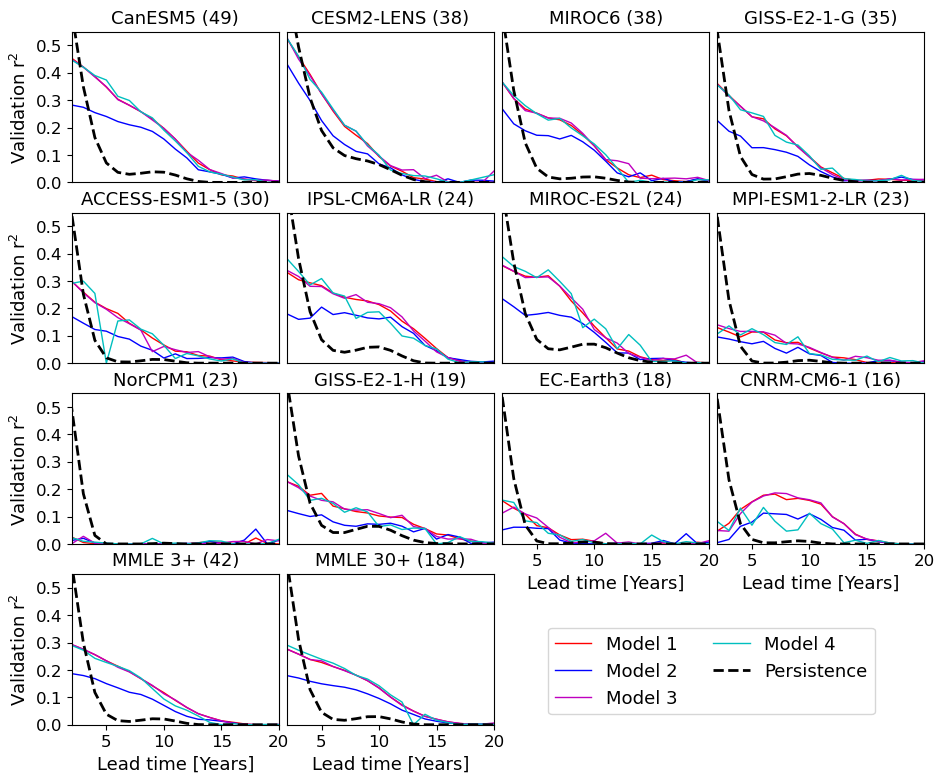

In [26]:
#plot R2 values for LE models with 16+ members for a single month and region
color_list = ['r', 'b', 'm', 'c']
style_list = ['-','-','-','-']
ML_model_name = ['Model 1', 'Model 2',
                 'Model 3', 'Model 4']

region_ = 2
month_ = 9

fig, axes = plt.subplots(4,4,figsize=[11,9])
for GCM_i in range(14):
    
    ax_x = int(np.floor(GCM_i/4))
    ax_y = GCM_i%4
    
    if GCM_i == 12:
        GCM = 'MMLE 3+ (42)'
        data = valid_r_CMIP6.sel(month=month_).sel(region=region_)**2        
        persist_low = xr.Dataset(persistence_lowpass).to_array()
        persist_low = persist_low.mean(
            'member').mean('variable').sel(region=region_).sel(
            month=month_)
        persist_low = persist_low.where(persist_low>0,0)**2
       
    elif GCM_i == 13:
        GCM = 'MMLE 30+ (184)'
        data = valid_r_CMIP6_30.where(valid_r_CMIP6_30>0,0)
        data = data.sel(month=month_).sel(region=region_)**2
        data = data.fillna(0.05832693) #interpolate nan for lag 13, ML_model 3
        persist_low = xr.Dataset(persistence_lowpass).to_array().sel(
            variable=['CanESM5', 'CESM2-LENS', 'MIROC6', 'GISS-E2-1-G', 
                      'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 
                      'MPI-ESM1-2-LR', 'NorCPM1',])
        persist_low = persist_low.mean('member').mean(
            'variable').sel(region=region_).sel(month=month_)
        persist_low = persist_low.where(persist_low>0,0)**2

    else:
        GCM = LE_GCM_15[GCM_i]
        data = valid_r[GCM].where(valid_r[GCM]>0,0)
        data = data.sel(month=month_).sel(region=region_)**2
        persist_low = persistence_lowpass[GCM].mean('member').sel(
            region=region_).sel(month=month_)
        persist_low = persist_low.where(persist_low>0,0)**2

    
    for ML_i in range(4):
        if GCM_i == 13:
            axes[ax_x][ax_y].plot(
                np.arange(1,21), data.sel(ML_model=ML_i),
                c=color_list[ML_i], linestyle=style_list[ML_i],
                label=ML_model_name[ML_i], linewidth=1)
        else:
            axes[ax_x][ax_y].plot(
                np.arange(1,21), data.sel(ML_model=ML_i),
                linestyle=style_list[ML_i], c=color_list[ML_i],
                linewidth=1)
       
            
    if GCM_i == 13:
        axes[ax_x][ax_y].plot(
            np.arange(1,21), persist_low, c='k', linestyle='--', linewidth=2,
            label='Persistence')
        
    else:
        axes[ax_x][ax_y].plot(
            np.arange(1,21), persist_low, linestyle='--', c='k', linewidth=2)


    axes[ax_x][ax_y].set_xlim(2,20)
    axes[ax_x][ax_y].set_ylim(0,0.55) #-15,10 SIT, -2.5,2 SIC

    axes[ax_x][ax_y].tick_params(axis='both', labelsize=12)

    if GCM_i > 9:
        axes[ax_x][ax_y].set_xticks([5,10,15,20])
        axes[ax_x][ax_y].set_xlabel('Lead time [Years]', fontsize=13)
    else:
        axes[ax_x][ax_y].set_xticks([])

    if ax_y==0:
        axes[ax_x][ax_y].set_yticks(np.arange(0,0.51,0.1)) 
        axes[ax_x][ax_y].set_ylabel(r'Validation r$^2$', fontsize=13) 
    else:
        axes[ax_x][ax_y].set_yticks([])

    if GCM_i < 12:
        axes[ax_x][ax_y].set_title(
            GCM+' ('+str(int(np.ceil(len(good_GCM_mem[GCM])*0.75)))+')',
            fontsize=13)
    else:
        axes[ax_x][ax_y].set_title(GCM,fontsize=13)

axes[3][1].legend(bbox_to_anchor=(2.05, 0.1), loc='lower center', 
            borderaxespad=-0.25, ncol=2, fontsize=13)
    
fig.delaxes(axes[3][2])
fig.delaxes(axes[3][3])

            
plt.subplots_adjust(hspace=0.2, wspace=0.04)
fig.savefig('/glade/work/cwpowell/low-frequency-variability/figures/'\
    +'Fig_2_ML_comparison_var_9_annual_Chukchi_Sep_best_season_LE_pos_persist.pdf', 
            bbox_inches='tight')

## Figure 3 (and S4) - Plot r$^2$ by region and month relative to persistence
**N.B. for Figure S4 `valid_r_GCM` is set to 0, leaving only `persist_GCM` (the persistence)**

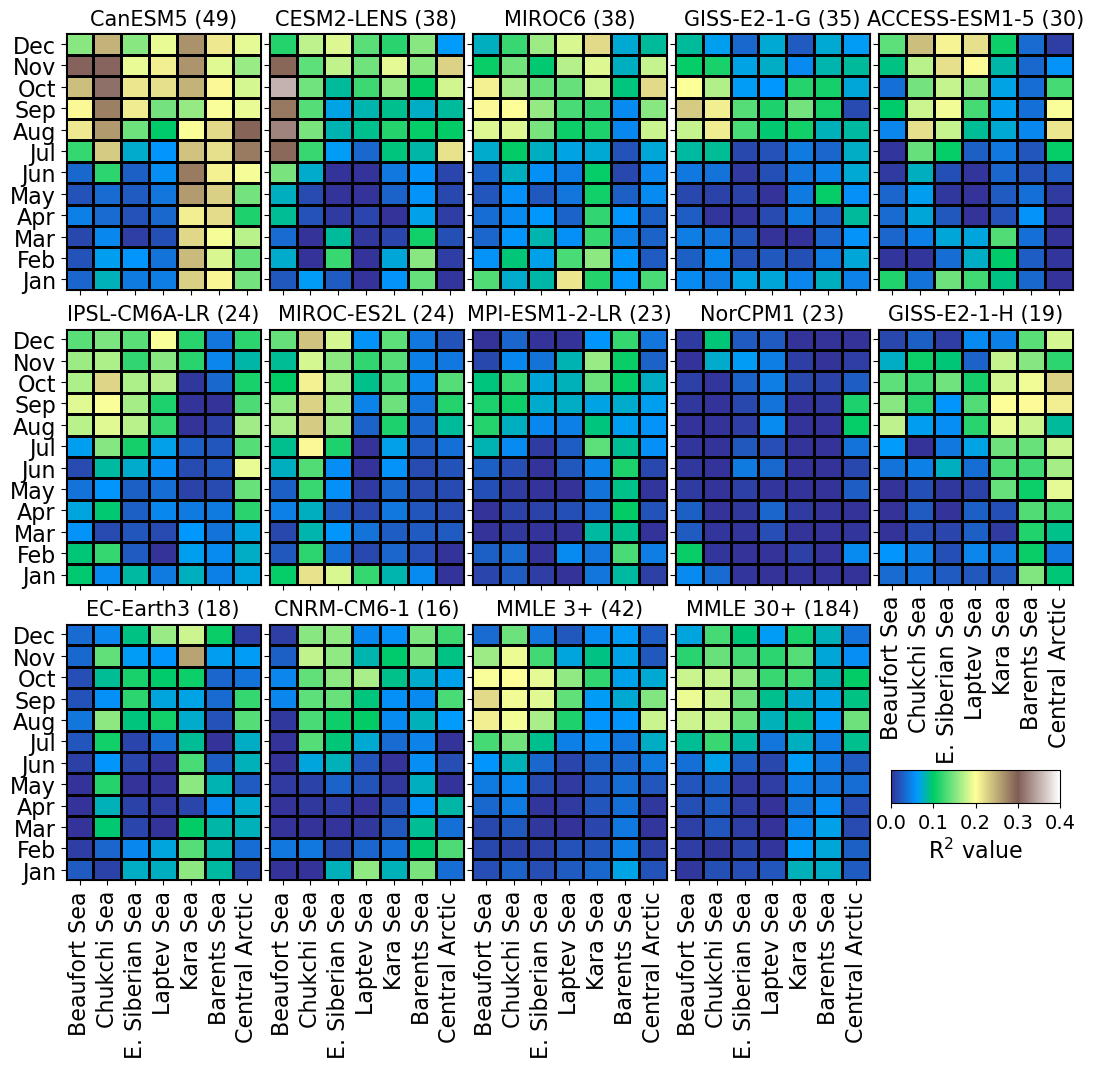

In [31]:
#just look at 5 year lag times and make 12x7 plot for each GCM and CMIP6
month_list = np.arange(1,13)
lag_ = 5

fig, axes = plt.subplots(3,5,figsize=[13,11])

for GCM_i, GCM in enumerate(LE_GCM_15[:-1]+['MMLE 3+']+['MMLE 30+']):
    persist_i = int(np.floor(GCM_i / 5))
    lag_i = int(GCM_i % 5)
    
    if GCM == 'MMLE 3+':
        valid_r_GCM = valid_r_CMIP6.sel(ML_model=0).sel(lag=lag_) 
        persist_GCM = xr.Dataset(persistence_lowpass).to_array().mean(
            'member').mean('variable').sel(lag=lag_).sel(month=month_list)
        
    elif GCM == 'MMLE 30+':
        valid_r_GCM = valid_r_CMIP6_30.sel(ML_model=0).sel(lag=lag_) 
        persist_GCM = xr.Dataset(persistence_lowpass).to_array().sel(variable=[
            'ACCESS-ESM1-5','CanESM5','CESM2-LENS','GISS-E2-1-G','IPSL-CM6A-LR',
            'MIROC-ES2L','MIROC6','MPI-ESM1-2-LR','NorCPM1']).mean('member').mean(
            'variable').sel(lag=lag_).sel(month=month_list)
        
    else:
        valid_r_GCM = valid_r[GCM].sel(ML_model=0).sel(lag=lag_)
        persist_GCM = persistence_lowpass[GCM].sel(
            month=month_list).sel(lag=lag_).mean('member')
    
    plot_data = valid_r_GCM.where(valid_r_GCM>0,0)**2 \
                - persist_GCM.where(persist_GCM>0,0)**2
    
    plotting = axes[persist_i][lag_i].pcolormesh(
        plot_data, cmap='terrain', vmin=0, vmax=0.4, edgecolors='k',)
        
    if persist_i == 2 or GCM_i == 9:
        axes[persist_i][lag_i].set_xticks(np.arange(0.5,7.5))
        axes[persist_i][lag_i].set_xticklabels(labels=
            ['Beaufort Sea', 'Chukchi Sea', 'E. Siberian Sea', 'Laptev Sea',
             'Kara Sea', 'Barents Sea', 'Central Arctic'
            ], rotation=90, fontsize=16)
    
    else:
        axes[persist_i][lag_i].set_xticks(np.arange(0.5,7.5))
        axes[persist_i][lag_i].set_xticklabels([])

    if GCM_i < 12:
        axes[persist_i][lag_i].set_title(
            GCM+' ('+str(int(np.ceil(len(good_GCM_mem[GCM])*0.75)))+')',
            fontsize=15)
    elif GCM_i == 12:
        axes[persist_i][lag_i].set_title('MMLE 3+ (42)', fontsize=15)
    elif GCM_i == 13:
        axes[persist_i][lag_i].set_title('MMLE 30+ (184)', fontsize=15)
    
    if lag_i == 0:
        axes[persist_i][lag_i].set_yticks(np.arange(0.5,12.5))
        axes[persist_i][lag_i].set_yticklabels(
            month_names_short, fontsize=16)
    else:
        axes[persist_i][lag_i].set_yticks(np.arange(0.5,12.5))
        axes[persist_i][lag_i].set_yticklabels([])

    if lag_i == 3 and persist_i == 1:
        # cbar_ax = fig.add_axes([0.91, 0.125, 0.02, 0.754])
        cbar_ax = fig.add_axes([0.76, 0.18, 0.13, 0.03])
        cbar = fig.colorbar(
            plotting, cax=cbar_ax, ticks=np.arange(0,0.41,0.1), 
            spacing='uniform', extend='neither', orientation='horizontal'
        )
        cbar.ax.tick_params(labelsize=14)
        cbar.ax.set_xlabel(r'R$^2$ value', fontsize=16)
                        
        
plt.subplots_adjust(hspace=0.15, wspace=0.04)        
fig.delaxes(axes[2][4])
fig.savefig('/glade/work/cwpowell/low-frequency-variability/figures/Fig_3_'\
            +'5_year_lag_var_9_annual_best_season_LE.pdf', bbox_inches = 'tight', 
            pad_inches = 0)

## Figure 1 - Map of regions and sea ice concentration time series

In [5]:
#load the region mask
masie_mask = xr.open_dataset('/glade/work/cwpowell/low-frequency-variability/'\
                             +'raw_data/masie_masks/masiemask_regrid_01_01_nn.nc')

#also load HadISST1 obs
HadISST1_regional = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/raw_data/sea_ice_obs/'\
    +'HadISST1_regional_SIC_area.nc')
lin_detrend = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/raw_data/sea_ice_obs/'\
    'HadISST1_1920-2022_regional_lin_detend_on_1920_2014.nc')
lowpass_filt = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/raw_data/sea_ice_obs/'\
    'HadISST1_1920-2022_regional_lowpass_filt_lin_detend_on_1920_2014.nc')

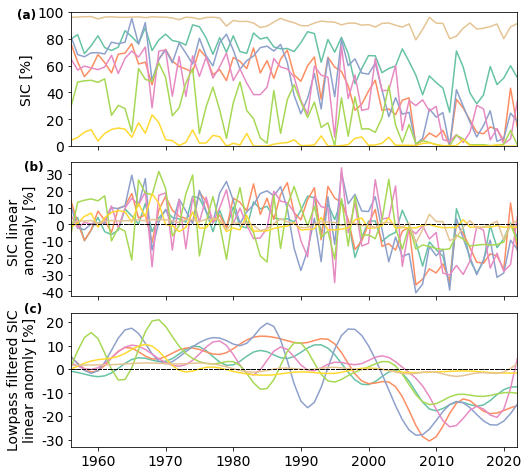

In [36]:
#make 3 part plot of raw, detrended, lowpass filtered obs
fig, axes = plt.subplots(3,1,figsize=[8,8])

cmap = plt.cm.Set2  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)] #all the colors in the cmap

for region_i, region_ in enumerate([1,2,3,4,5,6,11]):
    if region_ in [999]:
        continue
    axes[0].plot(np.arange(1920,2023), HadISST1_regional['SIC'].sel(
        time=HadISST1_regional['time.month']==9).sel(region=region_), c=cmaplist[region_i])
     
    axes[0].set_ylim(0,100)
    axes[0].set_xlim(1956,2022)
    axes[0].set_ylabel('SIC [%]', fontsize=14)
    axes[0].set_xticks(np.arange(1960,2021,10))
    axes[0].set_xticklabels('')
    axes[0].set_yticks(np.arange(0,101,20))
    axes[0].set_yticklabels(np.arange(0,101,20), fontsize=14)
    # axes[0].axvline(1956, color='k', linestyle='--', linewidth=1)
    
    
    axes[1].plot(np.arange(1920,2023), lin_detrend['SIC'].sel(
        month=9).sel(region=region_), c=cmaplist[region_i])
    axes[1].set_ylim(-43,37)
    axes[1].set_xlim(1956,2022)
    axes[1].set_ylabel('SIC linear '+'\n'+'anomaly [%]', 
                       fontsize=14)
    axes[1].set_xticks(np.arange(1960,2021,10))
    axes[1].set_xticklabels('')
    axes[1].set_yticks(np.arange(-40,31,10))
    axes[1].set_yticklabels(np.arange(-40,31,10), fontsize=14)
    axes[1].axhline(0, color='k', linestyle='--', linewidth=1)
    # axes[1].axvline(1956, color='k', linestyle='--', linewidth=1)
    
    
    axes[2].plot(np.arange(1920,2023), lowpass_filt['SIC'].sel(
        month=9).sel(region=region_), c=cmaplist[region_i])
    axes[2].set_ylim(-33,24)
    axes[2].set_xlim(1956,2022)
    axes[2].set_ylabel('Lowpass filtered SIC'+'\n'+'linear anomly [%]', 
                       fontsize=14)
    axes[2].set_xticks(np.arange(1960,2021,10))
    axes[2].set_xticklabels(np.arange(1960,2021,10), fontsize=14)
    axes[2].set_yticks(np.arange(-30,21,10))
    axes[2].set_yticklabels(np.arange(-30,21,10), fontsize=14)
    axes[2].axhline(0, color='k', linestyle='--', linewidth=1)
    # axes[2].axvline(1956, color='k', linestyle='--', linewidth=1)
    
fig.subplots_adjust(hspace=0.12)

axes[0].text(1948,95.5,'(a)',fontsize=12, fontweight='bold')
axes[1].text(1949,32,'(b)',fontsize=12, fontweight='bold')
axes[2].text(1949,24,'(c)',fontsize=12, fontweight='bold')

fig.savefig('/glade/work/cwpowell/low-frequency-variability/figures/Fig_1_'\
            +'SIC_anomaly_obs.pdf', bbox_inches='tight')

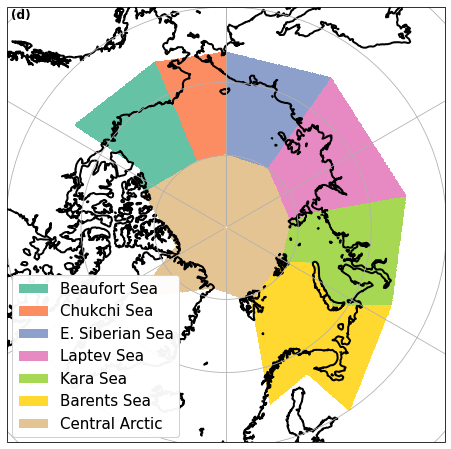

In [51]:
#define the colors
cmap = plt.cm.Set2  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)] #all the colors in the cmap

fig = plt.figure(figsize=[8,8])

ax = fig.add_subplot(1,1,1, 
    projection = ccrs.NorthPolarStereo(central_longitude=0))
ax.set_extent((-180,180,60,90), ccrs.PlateCarree())

#set boundary of subplots
theta = np.linspace(0, 2*np.pi, 100) #make the plot circular
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
# ax.set_boundary(circle, transform=ax.transAxes)
ax.set_facecolor('1')

masie_mask['regions'].where(masie_mask['regions'].isin([1,2,3,4,5,6,11])).plot(
    levels=[1,2,3,4,5,6,11,12], add_labels=False, add_colorbar=False,
    transform=ccrs.PlateCarree(), extend='neither', 
    linewidths=1e-10, edgecolors='face', colors=cmaplist)    

ax.coastlines(lw=2)
ax.gridlines();
ax.text(-3.35e6,3.25e6,'(d)',fontsize=12, fontweight='bold')

legend_elements = []
for region_i, region_ in enumerate([1,2,3,4,5,6,11]):
    legend_elements.append(
        Patch(facecolor=cmaplist[region_i], ec='1', 
              label=region_names_short[region_-1])
    )
            
extra_legend = plt.legend(
    handles=legend_elements, bbox_to_anchor=(0.01, 0.01), loc='lower left',
    borderaxespad=0., ncol=1, fontsize=15)

plt.gca().add_artist(extra_legend);
fig.savefig('/glade/work/cwpowell/low-frequency-variability/figures/Fig_1_'\
            +'region_map.pdf', bbox_inches='tight')

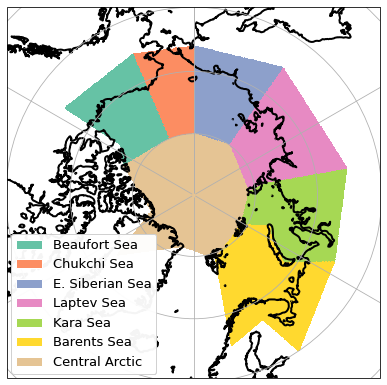

In [214]:
#define the colors
cmap = plt.cm.Set2  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)] #all the colors in the cmap

fig = plt.figure(figsize=[15,15])

ax = fig.add_subplot(2,2,4, 
    projection = ccrs.NorthPolarStereo(central_longitude=0))
ax.set_extent((-180,180,60,90), ccrs.PlateCarree())

#set boundary of subplots
theta = np.linspace(0, 2*np.pi, 100) #make the plot circular
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
# ax.set_boundary(circle, transform=ax.transAxes)
ax.set_facecolor('1')


masie_mask['regions'].where(masie_mask['regions'].isin([1,2,3,4,5,6,11])).plot(
    levels=[1,2,3,4,5,6,11,12], add_labels=False, add_colorbar=False,
    transform=ccrs.PlateCarree(), extend='neither', 
    linewidths=1e-10, edgecolors='face', colors=cmaplist)    


ax.coastlines(lw=2)
ax.gridlines();

legend_elements = []
for region_i, region_ in enumerate([1,2,3,4,5,6,11]):
    legend_elements.append(
        Patch(facecolor=cmaplist[region_i], ec='1', 
              label=region_names_short[region_-1])
    )
            
extra_legend = plt.legend(
    handles=legend_elements, bbox_to_anchor=(0.01, 0.01), loc='lower left',
    borderaxespad=0., ncol=1, fontsize=13)

plt.gca().add_artist(extra_legend);
fig.savefig('/glade/work/cwpowell/low-frequency-variability/figures/Fig_1_'\
            +'region_map.pdf', bbox_inches=0, pad_inches = 0)